In [9]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

###SDM model ensemble

### overall species richness  all taxa combined

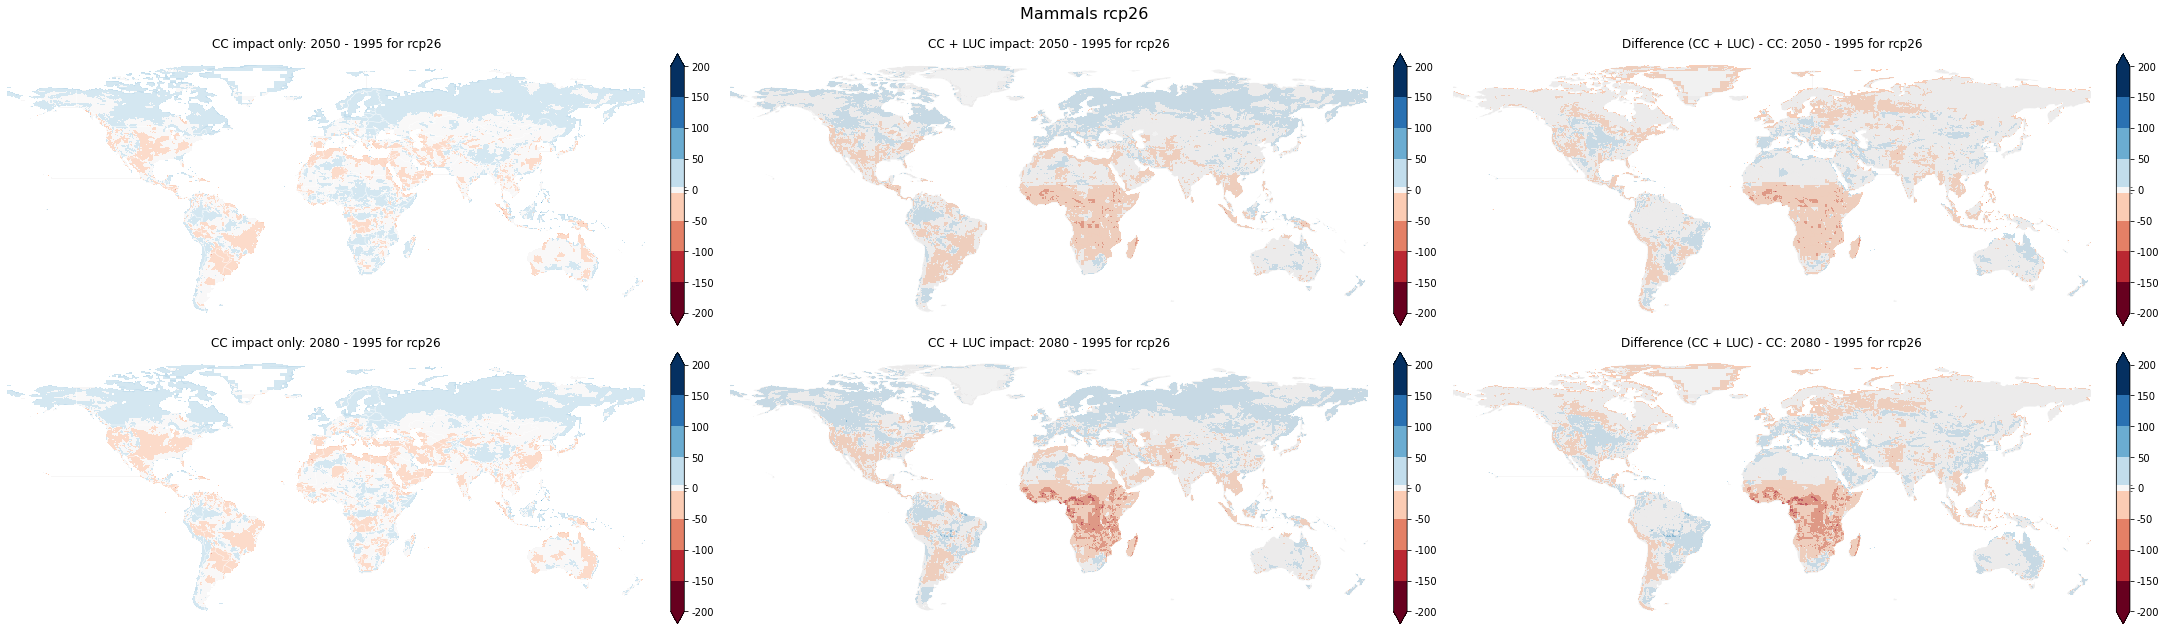

In [12]:
### SDM MODEL ENSEMBLE RCP26 ##### 

warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM","GBM"]
taxas = ["Mammals"]
scenarios = ["rcp26"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    for scenario in scenarios:
        historical_time = 1146
        future_times = [35, 65]
        model_names = [ 'GFDL-ESM2M','IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # create empty arrays for storing the results
        diff_value_bin_combined = np.zeros([360, 720])
        diff_sum_bin_combined = np.zeros([360, 720])
        diff_combined = np.zeros([360, 720])


        for future_time in future_times:
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []

            for model in models:
                newvalue_hist = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_00th_mean_value_bin_future.nc"

                sumbin_hist = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"


                mean_value_bin_hist = xr.open_dataset(newvalue_hist,decode_times=False).to_array()
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist,decode_times=False).to_array()
                #mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                #mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                newvalue_fut = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_00th_mean_value_bin_future.nc"

                sumbin_fut = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"

                mean_value_bin_future = xr.open_dataset(newvalue_fut,decode_times=False).to_array()
                mean_sum_bin_future = xr.open_dataset(sumbin_fut,decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                diff = diff_sum_bin - diff_value_bin

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

            # Calculate the ensemble mean outside of the inner loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
            diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Create three subplots for each future time and scenario
            if plot_idx >= len(axes.flatten()):
                break
            ax1 = axes.flatten()[plot_idx]
            ax2 = axes.flatten()[plot_idx + 1]
            ax3 = axes.flatten()[plot_idx + 2]

            labels = ['a', 'b', 'c']
            # Define the colormap and the range of values for the colorbar
            vmin_b = diff_sum_bin.min().values
            vmax_b = diff_sum_bin.max().values

            cmap = plt.colormaps['RdBu']
            boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
            norm = BoundaryNorm(boundaries, cmap.N)

            # Plot the ensemble mean difference for each panel
            im1 = ax1.pcolormesh(diff_value_bin_ensemble['lon'].values, diff_value_bin_ensemble['lat'].values, np.where(diff_value_bin_ensemble.values != 0, diff_value_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

            countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
            ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')


            ax1.axis('off')
            ax1.set_extent((-180,180,-63,90))
            ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

            ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
            tick_labels = [str(int(tick)) for tick in ticks_b]

            cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar1.set_ticklabels(tick_labels)



            im2 = ax2.pcolormesh(diff_sum_bin_ensemble['lon'].values, diff_sum_bin_ensemble['lat'].values,  np.where(diff_sum_bin_ensemble.values != 0, diff_sum_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

            countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

            ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

            ax2.axis('off')
            ax2.set_extent((-180,180,-63,90))
            cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar2.set_ticklabels(tick_labels)


            # ------------------------------------------------
            # Panel c 


            boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
            norm = BoundaryNorm(boundaries, cmap.N)
            cmap = plt.colormaps['RdBu']

            im3 = ax3.pcolormesh(diff_ensemble['lon'].values, diff_ensemble['lat'].values,  np.where(diff_ensemble.values != 0, diff_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

            countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
            ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

            ax3.axis('off')
            ax3.set_extent((-180,180,-63,90))

            ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
            tick_labels = [str(int(tick)) for tick in ticks_b]

            cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
            cbar3.set_ticklabels(tick_labels)
            # Increase the plot index by 3 to move to the next triplet of subplots
            plot_idx += 3


        plt.suptitle(taxa +" "+ scenario , size=16, y=0.8)
        #plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/species_richness_lu_binary" + taxa +  "_" + scenario)

    #plt.show() 


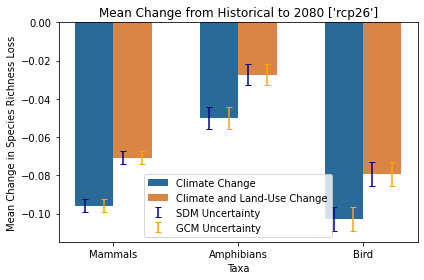

In [34]:
time=[65]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
taxas = ["Mammals","Amphibians","Bird"]  # Add the second taxa here
scenario = ["rcp26"]
historical_time=1146

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']


# Create the dictionaries
newvalue_dict_fut = {}
newvalue_dict_hist = {}
sumbin_dict_future = {}
sumbin_dict_hist = {}

# Initialize the dictionaries with SDM, GCM, and taxa keys
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for sdm in sdms:
    newvalue_dict_fut[sdm] = {}
    newvalue_dict_hist[sdm] = {}
    sumbin_dict_future[sdm] = {}
    sumbin_dict_hist[sdm] = {}
    mean_newvalue_change[sdm] = {}
    mean_sum_bin_change[sdm] = {}
    mean_land_use_change[sdm] = {}

    for gcm in gcms:
        newvalue_dict_fut[sdm][gcm] = {}
        newvalue_dict_hist[sdm][gcm] = {}
        sumbin_dict_future[sdm][gcm] = {}
        sumbin_dict_hist[sdm][gcm] = {}
        mean_newvalue_change[sdm][gcm] = {}
        mean_sum_bin_change[sdm][gcm] = {}
        mean_land_use_change[sdm][gcm] = {}

        for taxa in taxas:
            newvalue_dict_fut[sdm][gcm][taxa] = []
            newvalue_dict_hist[sdm][gcm][taxa] = []
            sumbin_dict_future[sdm][gcm][taxa] = []
            sumbin_dict_hist[sdm][gcm][taxa] = []

# Loop over all taxa
for taxa in taxas:
    for sdm in sdms:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + sdm + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

        species_names = available_names[:10]
        # Define the netCDF file path
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        # Loop over all species
        for species_name in species_names:
            # Loop over all models
            for gcm in gcms:
                # Open the netCDF files
                ds_newvalue_fut = xr.open_dataset(
                    netcdf_path_format_future.format(sdm, taxa, gcm, scenario[0], species_name, time[0]),
                    decode_times=False
                )
                ds_newvalue_hist = xr.open_dataset(
                    netcdf_path_format_hist.format(sdm, taxa, species_name, historical_time),
                    decode_times=False
                )

                # Get the newvalue and sum_bin
                
                newvalue_fut = ds_newvalue_fut["newvalue"]
                newvalue_hist = ds_newvalue_hist["newvalue"]
                sum_bin_future = ds_newvalue_fut["sum_bin"].isel(time=0)
                sum_bin_hist = ds_newvalue_hist["sum_bin"].isel(time=0)

                # Append the newvalue to the dictionaries
                newvalue_dict_fut[sdm][gcm][taxa].append(newvalue_fut)
                newvalue_dict_hist[sdm][gcm][taxa].append(newvalue_hist)
                sumbin_dict_future[sdm][gcm][taxa].append(sum_bin_future)
                sumbin_dict_hist[sdm][gcm][taxa].append(sum_bin_hist)
                
                
# Calculate the mean change from historical to future per sdm, per gcm, per taxa
for sdm in newvalue_dict_fut:
    for gcm in newvalue_dict_fut[sdm]:
        for taxa in newvalue_dict_fut[sdm][gcm]:
            if len(newvalue_dict_hist[sdm][gcm][taxa]) > 0 and len(newvalue_dict_fut[sdm][gcm][taxa]) > 0:
                newvalue_hist = xr.concat(newvalue_dict_hist[sdm][gcm][taxa], dim="species").sum(dim="species")
                newvalue_future = xr.concat(newvalue_dict_fut[sdm][gcm][taxa], dim="species").sum(dim="species")
                sum_bin_hist =  xr.concat(sumbin_dict_hist[sdm][gcm][taxa], dim="species").sum(dim="species")
                sum_bin_future = xr.concat(sumbin_dict_future[sdm][gcm][taxa], dim="species").sum(dim="species")
                                
                climate_change = (newvalue_future - newvalue_hist)  # Calculate change as percentage
                climate_land_change = (sum_bin_future - sum_bin_hist)
                land_use_change = (climate_land_change - climate_change) 
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))
               

                  
                land_use_change = (climate_land_change - climate_change) 

                mean_newvalue_change[sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[sdm][gcm][taxa] = climate_land_change_loss
                mean_land_use_change[sdm][gcm][taxa] = land_use_change
                
# Calculate the mean change and uncertainties for Mammals, Amphibians, and Birds
mean_values = {}
mean_sum_bin_change_taxa = {}  # Rename this to avoid conflicts
uncertainties_sdm_taxa = {}     # Rename this to avoid conflicts
uncertainties_gcm_taxa = {}     # Rename this to avoid conflicts

for taxa in taxas:
    mean_values[taxa] = []
    mean_sum_bin_change_taxa[taxa] = []  # Update the dictionary name
    uncertainties_sdm_taxa[taxa] = []     # Update the dictionary name
    uncertainties_gcm_taxa[taxa] = []     # Update the dictionary name
    
    for sdm in sdms:
        sdm_values = []
        sdm_land_use_values = []
        for gcm in gcms:
            sdm_values.append(mean_newvalue_change[sdm][gcm][taxa].mean().item())
            sdm_land_use_values.append(mean_sum_bin_change[sdm][gcm][taxa].mean().item())
        mean_values[taxa].append(np.mean(sdm_values))
        mean_sum_bin_change_taxa[taxa].append(np.mean(sdm_land_use_values))
        uncertainties_sdm_taxa[taxa].append(np.std(sdm_values))

        gcm_values = []  # Moved this block inside the 'taxa' loop
        gcm_land_use_values = []  # Moved this block inside the 'taxa' loop
        for gcm in gcms:
            gcm_values.append(mean_newvalue_change[sdm][gcm][taxa].mean().item())
            gcm_land_use_values.append(mean_sum_bin_change[sdm][gcm][taxa].mean().item())
        uncertainties_gcm_taxa[taxa].append(np.std(gcm_values))
        
# Set up the bar plot
indices = [(1,2,3,4,5)]
x_labels = taxas

fig, ax = plt.subplots()

taxa_list = ["Mammals", "Amphibians", "Bird"]
color_change = "#2a6a99"  
color_land_use_change = "#d88546" 
color_sdm_uncertainty = "navy"  # A shade of green
color_gcm_uncertainty = "orange"  # A shade of purple


bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxa_list)) * (2 * bar_width + 0.5)

for i, taxa in enumerate(taxa_list):
    x_shift = x_positions[i]

    if not i:
        ax.bar(x_shift, np.mean(mean_values[taxa]), width=bar_width, color=color_change, label='Climate Change')
        ax.bar(x_shift + bar_width,  np.mean(mean_sum_bin_change_taxa[taxa]), width=bar_width, alpha=1, color=color_land_use_change, label='Climate and Land-Use Change')    
        ax.errorbar(x_shift - error_bar_shift, np.mean(mean_values[taxa]), yerr= np.mean(uncertainties_sdm_taxa[taxa]), fmt='none', capsize=3, color=color_sdm_uncertainty, label='SDM Uncertainty')
        ax.errorbar(x_shift + error_bar_shift, np.mean(mean_values[taxa]), yerr= np.mean(uncertainties_gcm_taxa[taxa]), fmt='none', capsize=3, color=color_gcm_uncertainty, label='GCM Uncertainty')
        ax.errorbar(x_shift + bar_width - error_bar_shift, np.mean(mean_sum_bin_change_taxa[taxa]), yerr= np.mean(uncertainties_sdm_taxa[taxa]), fmt='none', capsize=3, color=color_sdm_uncertainty)
        ax.errorbar(x_shift + bar_width + error_bar_shift, np.mean(mean_sum_bin_change_taxa[taxa]), yerr= np.mean(uncertainties_gcm_taxa[taxa]), fmt='none', capsize=3, color=color_gcm_uncertainty)
    else:
        ax.bar(x_shift,  np.mean(mean_values[taxa]), width=bar_width, color=color_change)
        ax.bar(x_shift + bar_width, np.mean(mean_sum_bin_change_taxa[taxa]), width=bar_width, alpha=1, color=color_land_use_change)  
        ax.errorbar(x_shift - error_bar_shift,np.mean(mean_values[taxa]), yerr= np.mean(uncertainties_sdm_taxa[taxa]), fmt='none', capsize=3, color=color_sdm_uncertainty)
        ax.errorbar(x_shift + error_bar_shift,np.mean(mean_values[taxa]), yerr= np.mean(uncertainties_gcm_taxa[taxa]), fmt='none', capsize=3, color=color_gcm_uncertainty)
        ax.errorbar(x_shift + bar_width - error_bar_shift,np.mean(mean_sum_bin_change_taxa[taxa]), yerr= np.mean(uncertainties_sdm_taxa[taxa]), fmt='none', capsize=3, color=color_sdm_uncertainty)
        ax.errorbar(x_shift + bar_width + error_bar_shift, np.mean(mean_sum_bin_change_taxa[taxa]), yerr= np.mean(uncertainties_gcm_taxa[taxa]), fmt='none', capsize=3, color=color_gcm_uncertainty)


# Set up the x-axis labels and ticks
ax.set_xticks(x_positions + bar_width*0.5)
ax.set_xticklabels(taxa_list)

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Convert the first element of the 'time' list to an integer
time = int(time[0])

# Set labels, ticks, and title
ax.set_xlabel('Taxa')
ax.set_ylabel('Mean Change in Species Richness Loss')
ax.set_title(f'Mean Change from Historical to {year_indices[time]} {scenario}')

ax.legend()
plt.legend()
plt.tight_layout()
plt.show()


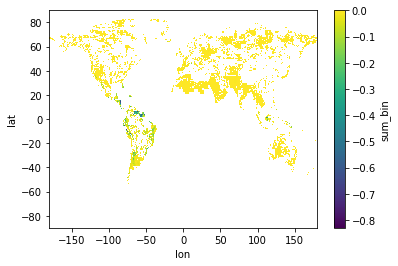

In [31]:
climate_land_change_loss.plot()

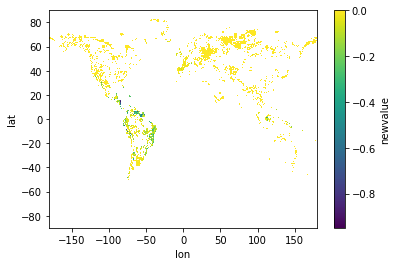

In [32]:
climate_change_loss.plot()